### **Convolutional Neural Networks, and Large Scale Visual Recognition Project**
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. 



#### **5. Fine-tuning ResNet to the COCO-Dataset 80-category dataset**
Grading: 7pts - Optional for extra credit - but no partial credit on this question)

The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, nor use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

In [0]:
# Download COCO API
!git clone https://github.com/cocodataset/cocoapi
%cd cocoapi/PythonAPI
!make
%cd ../..

In [0]:
# Unzip train images
from zipfile import ZipFile 
for i in range(10):
  with ZipFile("train_samples"+str(i)+".zip", 'r') as zip_f1: 
      zip_f1.extractall() 

In [0]:
# Load train id list
import json
fo = open("train_ID_list.txt", "r")
output = fo.read()
trainIdList = json.loads(output)
print(len(trainIdList), type(trainIdList))

trainFullIds = []
for imgId in trainIdList:
  fullId = ""
  for k in range(12-len(str(imgId))):
    fullId += "0"
  fullId += (str(imgId)+".jpg")
  trainFullIds.append(fullId)
print(len(trainFullIds), type(trainFullIds[0]))
print(trainFullIds[0])

In [0]:
# Merge train images
import shutil
for i in range(10):
  for j in range(i*2000, (i+1)*2000):
    fullId = str(trainFullIds[j])
    oldDir = "./train_samples"+ str(i) + "/" + fullId + ".jpg"
    newDir = "./train_samples/" + fullId + ".jpg"
    shutil.move(oldDir, newDir)

In [0]:
# Test merging
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("./train_samples/000000000382.jpg")
plt.imshow(img)

In [0]:
# Unzip validation images
from zipfile import ZipFile 
with ZipFile("validation_samples.zip", 'r') as zip_f2: 
    zip_f2.extractall() 

In [0]:
# Load val id list
import json
fo = open("validation_ID_list.txt", "r")
output = fo.read()
valIdList = json.loads(output)
print(len(valIdList), type(valIdList))

valFullIds = []
for imgId in valIdList:
  fullId = ""
  for k in range(12-len(str(imgId))):
    fullId += "0"
  fullId += (str(imgId)+".jpg")
  valFullIds.append(fullId)
print(len(valFullIds), type(valFullIds[0]))
print(valFullIds[0])

In [0]:
# Load COCO
from pycocotools.coco import COCO
cocoVal = COCO("/content/instances_val2017.json")
cocoTrain = COCO("/content/instances_train2017.json")

In [0]:
# Load all categories
cats = cocoTrain.loadCats(cocoTrain.getCatIds())
nms_train =[cat['name'] for cat in cats]
print(len(nms_train))
cats = cocoVal.loadCats(cocoVal.getCatIds())
nms_val =[cat['name'] for cat in cats]
print(len(nms_val))

In [0]:
# Define dataset
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os.path as path
import torchvision.datasets as dset
import torchvision.transforms as transforms

class COCODataset(Dataset):
  def __init__(self, trainOrVal, transform=None):
    self.transform = transform
    self.isTrain = True if trainOrVal == "train" else False
    self.directory = "./train_samples/" if self.isTrain else "./validation_samples/"
    self.imgList = trainFullIds if self.isTrain else valFullIds
    self.coco = cocoTrain if self.isTrain else cocoVal
    self.nms = nms_train if self.isTrain else nms_val

  def __len__(self):
    return 20000 if self.isTrain else 1000

  def __getitem__(self, idx):
    img = Image.open(self.directory + self.imgList[idx])
    if img.mode == "L":
      img = img.convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img
  
  # imgId ==> list of labels for a single image
  def getLabels(self, imgId):
      annIds  = self.coco.getAnnIds(imgIds=[imgId])
      anns = self.coco.loadAnns(annIds)
      categoryIds = [ann["category_id"] for ann in anns]
      categories = list(set(cat["name"] for cat in cocoVal.loadCats(categoryIds)))
      return categories

  def generateY(self, imgId):
    y = []
    labels = self.getLabels(imgId)
    for label in self.nms:
      y.append(1) if label in labels else y.append(0)
    return y

preprocessFn = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

train_set = COCODataset("train", preprocessFn)
val_set = COCODataset("val", preprocessFn)
trainLoader = DataLoader(train_set, batch_size=125, shuffle=False, num_workers=0)
valLoader = DataLoader(val_set, batch_size=125, shuffle=False, num_workers=0)

In [0]:
# Define model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

classifier = models.resnet18(pretrained = True)
print(classifier.fc)
classifier.fc = nn.Sequential(nn.Linear(512, 80, bias=True), nn.LogSoftmax(dim=1))
print(classifier.fc)

train_acc, train_loss, val_acc, val_loss = [],[],[],[]
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(classifier.parameters(), lr = 0.05)

In [158]:
# Train model
def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  classifier.cuda()
  for epoch in range(0, n_epochs):
    correct = 0
    cumloss = 0
    classifier.train()
    for i, x in enumerate(trainLoader):
      x = x.cuda()
      y_t = [train_set.generateY(trainIdList[i*125+j]) for j in range(125)]
      y = torch.FloatTensor(y_t).cuda()
      yhat = classifier(x)
      loss = criterion(yhat, y)
      if i%10 == 0:
        print(i, loss.item()/125)
      optimizer.zero_grad() 
      loss.backward()
      optimizer.step()
      
      with torch.no_grad(): 
        # correct += torch.eq(torch.argmax(yhat, dim=1),y).sum().item(
        cumloss += loss.item()

    n = len(train_set)
    print('({0}) Training: loss = {1:.4f}, accuracy = {2:.4f}'
      .format(epoch, cumloss / n, correct / n))
    train_acc.append(correct/n)
    train_loss.append(cumloss/n)
    
    correct = 0
    cumloss = 0
    with torch.no_grad():
      classifier.eval()
      for i, x in enumerate(valLoader):
        x = x.cuda()
        y_t = [val_set.generateY(valIdList[i*125+j]) for j in range(125)]
        y = torch.FloatTensor(y_t).cuda()
        yhat = classifier(x)
        loss = criterion(yhat, y)
        print(i, loss.item()/125)
        # correct += torch.eq(torch.argmax(yhat, dim=1),y).sum().item()
        cumloss += loss.item()
        
    n = len(val_set)
    print('({0}) Validation: loss = {1:.4f}, accuracy = {2:.4f}'
      .format(epoch, cumloss / n, correct / n))
    print('\n')
    val_acc.append(correct/n)
    val_loss.append(cumloss/n)

 
train_model(classifier, criterion, optimizer, 
           trainLoader, valLoader, n_epochs = 10)

0 0.0014887003898620605
10 0.001424710750579834
20 0.0012329000234603882
30 0.001282128930091858
40 0.0012038136720657349
50 0.0011559884548187256
60 0.0012751706838607787
70 0.0012240333557128906
80 0.0010843311548233033
90 0.0010783462524414063
100 0.001220915198326111
110 0.0012427113056182862
120 0.0011030099391937257
130 0.0012488348484039308
140 0.0012227007150650024
150 0.0011480716466903686
(0) Training: loss = 0.0013, accuracy = 0.0000
0 0.0012454180717468262
1 0.0013080861568450929
2 0.0011460765600204467
3 0.0011694985628128052
4 0.0011890076398849488
5 0.0011713736057281494
6 0.001228694796562195
7 0.0013607367277145386
(0) Validation: loss = 0.0012, accuracy = 0.0000


0 0.0012740727663040161
10 0.0012740718126296997
20 0.001111432671546936
30 0.0011916548013687135
40 0.0011313945055007935
50 0.0010746029615402222
60 0.0012011688947677613
70 0.0011572376489639281
80 0.0010305715799331665
90 0.0010241626501083375
100 0.0011621778011322022
110 0.001189739465713501
120 0.0010

Examples#1:

Predicted Labels(Top 10): 
['person', 'dining table', 'bowl', 'knife', 'cup', 'spoon', 'pizza', 'bottle', 'carrot', 'fork']
True Labels: 
['bottle', 'wine glass', 'bowl', 'pizza', 'spoon', 'person', 'fork', 'dining table']
Correctness : 7/8



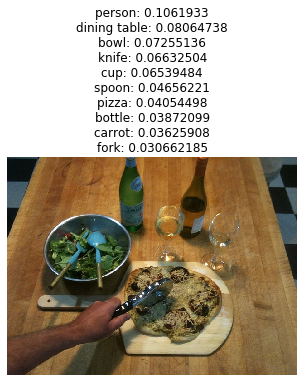



Examples#2:

Predicted Labels(Top 10): 
['person', 'dining table', 'cup', 'fork', 'bowl', 'sandwich', 'chair', 'pizza', 'knife', 'banana']
True Labels: 
['bird', 'chair', 'knife', 'fork', 'person', 'sandwich', 'cup', 'dining table']
Correctness : 7/8



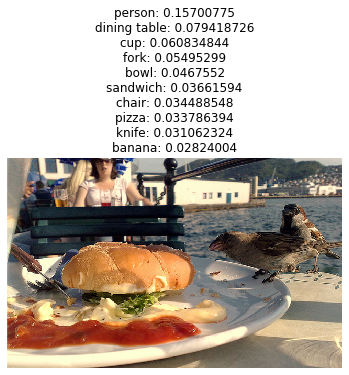



Examples#3:

Predicted Labels(Top 10): 
['dining table', 'knife', 'person', 'cake', 'cup', 'bowl', 'spoon', 'bottle', 'sandwich', 'fork']
True Labels: 
['bowl', 'knife', 'fork', 'person', 'donut', 'sandwich', 'cup', 'dining table']
Correctness : 7/8



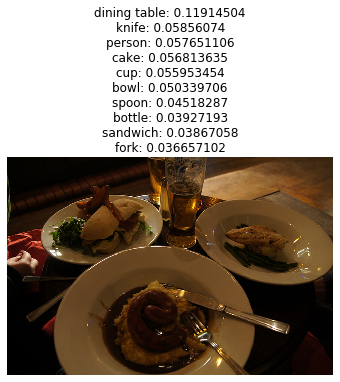

In [222]:
import torch.nn.functional as F
val_set2 = COCODataset("val")
samples = 0
for i in range(1000):
  if samples >= 3:
    break
  inputVector = val_set[i].cuda().unsqueeze(0)
  predictions = classifier(inputVector)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = probs.cpu()
  indices = indices.cpu()
  probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
  labels = [nms_val[idx] for (prob, idx) in zip(probs, indices)]
  preds = [nms_val[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
  count = 0
  groundTruth = val_set.getLabels(valIdList[i])
  for pred in labels:
    if pred in groundTruth:
      count +=1
  if len(groundTruth)!=0 and (float(count)/len(groundTruth)) >= 0.8 and len(groundTruth) > 7:
    samples +=1
    print("Examples#" + str(samples) + ":\n")
    print("Predicted Labels(Top 10): \n" + str(labels))
    print("True Labels: \n" + str(groundTruth))
    print("Correctness : " + str(count) + "/" + str(len(groundTruth)) + "\n")
    plt.figure()
    plt.title('\n'.join(preds))
    plt.imshow(val_set2[i]); plt.grid(False); plt.axis('off'); plt.show()
    print("\n=========================================================\n")

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?